# Instalaciómn y carga de dependencias

In [1]:
!pip install --upgrade scikit-learn xgboost optuna langdetect dask[dataframe] #Actualizar para que no haya incompatibilidades

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=e1e2bd3dad69d9a3caa370d35968e96bc7c39f18011b9d9e20b5af5829694de5
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0


In [2]:
import re
import inflect
from collections import Counter
from datetime import datetime

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import spacy
from langdetect import detect
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import optuna

from IPython import get_ipython
from IPython.display import display

# 1- Carga del dataset

In [ ]:
full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')

# 2- Imputación de valores en price por rango de precio

In [ ]:
# 1. Estimación inicial: Rellenar NaN en "Price" con la media global
full_df["Price"] = full_df["Price"].fillna(full_df["Price"].mean())

# 2. Calcular rangos iniciales
full_df["Price_Range"] = pd.cut(full_df["Price"], bins=[0, 50, 100, 200, 500, 1000], labels=["0-50", "50-100", "100-200", "200-500", "500-1000"])

# 3. Iterar para refinar la imputación
max_iter = 10  # Número máximo de iteraciones
for _ in range(max_iter):
    prev_price = full_df["Price"].copy()  # Guardar los valores anteriores de "Price"

    # Rellenar NaN en "Price" con la media del rango
    for price_range in full_df["Price_Range"].unique():
        mask = full_df["Price_Range"] == price_range
        mean_price = full_df.loc[mask, "Price"].mean()
        full_df.loc[mask & full_df["Price"].isnull(), "Price"] = mean_price

    # Recalcular "Price_Range"
    full_df["Price_Range"] = pd.cut(full_df["Price"], bins=[0, 50, 100, 200, 500, 1000], labels=["0-50", "50-100", "100-200", "200-500", "500-1000"])

    # Verificar convergencia
    if full_df["Price"].equals(prev_price):
        break  # Salir del bucle si los valores no cambian
price_range_counts = full_df["Price_Range"].value_counts()
print(price_range_counts)
#Una vez creado los rango, les asignamos un label para que pueda estratificar
full_df["Price_Category"] = pd.cut(full_df["Price"],
                                     bins=[0, 50, 100, 200, 500, 1000],
                                     labels=[0, 1, 2, 3, 4])

# 3 - Split en train y test con estratficación por rango de precio

In [3]:
# Split estratificado por rango de precios
train, test = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df["Price_Category"])

# Eliminar la columna auxiliar
train.drop(columns=["Price_Range","Price_Category"], inplace=True)
test.drop(columns=["Price_Range", "Price_Category"], inplace=True)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

Price_Range
0-50        6852
50-100      5474
100-200     1882
200-500      509
500-1000      63
Name: count, dtype: int64
Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


In [4]:
test["Price"].describe()

,Price
count,2956.000000
mean,73.872356
std,74.307079
min,10.000000
25%,35.000000
50%,55.000000
75%,85.000000
max,999.000000


In [5]:
train["Price"].describe()

,Price
count,11824.000000
mean,73.483750
std,71.440545
min,9.000000
25%,34.000000
50%,55.000000
75%,86.250000
max,969.000000


In [6]:
df = pd.read_csv('./train.csv', sep=';', decimal='.')
df.head().T

,0,1,2,3,4
ID,5063029,1039376,16717381,7249944,17391616
Listing Url,https://www.airbnb.com/rooms/5063029,https://www.airbnb.com/rooms/1039376,https://www.airbnb.com/rooms/16717381,https://www.airbnb.com/rooms/7249944,https://www.airbnb.com/rooms/17391616
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,Apartamento nº 10 Puerta del Sol,Cozy apartment near Madrid airport,Habitación económica céntrica Malasaña,Purificación,ACOGEDOR APARTAMENTO EN LAVAPIES
Summary,Apartamento Atico de lujo en el centro de Madr...,"Este piso, pequeño pero acogedor y equipado co...","El piso está muy céntrico, en la zona norte de...","Se trata de un piso luminoso, reformado hace u...",Acogedor apartamento ubicado en el barrio lava...
Space,NaN,"1 bedroom flat, 35 sq metres, situated on the ...",La casa consta de una habitación principal con...,NaN,Estarás a pocos minutos caminando de los lugar...
Description,Apartamento Atico de lujo en el centro de Madr...,"1 bedroom flat, 35 sq metres, situated on the ...","El piso está muy céntrico, en la zona norte de...","Se trata de un piso luminoso, reformado hace u...",Acogedor apartamento ubicado en el barrio lava...
Experiences Offered,none,none,none,none,none
Neighborhood Overview,NaN,NaN,"Es quizás el mayor atractivo del piso, su ubic...",NaN,"Se encuentra situado en el barrio de Lavapiés,..."


#4 - Análisis exploratorio, imputación de valores nulos, categorización de variables numéricas y categóricas. Análisis NLP.

Revisar columnas con más valores nulos

In [7]:
train.isnull().sum().sort_values(ascending=False).head(20)

,0
Has Availability,11813
Host Acceptance Rate,11790
Jurisdiction Names,11638
License,11550
Square Feet,11348
Monthly Price,8975
Weekly Price,8973
Notes,7281
Security Deposit,6818
Interaction,5237


Eliminar columnas con alto número de nulos

In [8]:
cols_to_drop = ['Has Availability', 'Host Acceptance Rate', 'Jurisdiction Names', 'License', 'Square Feet']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)

In [ ]:
train.describe()

En los valores numéricos podemos imputar los valores nulos con la media o mediana y esto va a dependender de la distribución de los datos. Si los datos siguen una distribución simétrica usaremos la media y si no la mediana. Para automatizar esta decisión podríamos usar skew() pero no lo se hace para que quede en relieve el paso a paso que se ha tomado para toda la limpieza del dataset y como se han convertido variables numericas, categórica(con diferentes encoders explicados abajo) y analizado el lenguaje(NLP con Scipy) en el transcurso del análisis.

In [ ]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
skew_values = train[numeric_cols].skew()

In [9]:
# Rellenar valores numéricos con la mediana
train['Security Deposit'] = train['Security Deposit'].fillna(train['Security Deposit'].median())
train['Cleaning Fee'] = train['Cleaning Fee'].fillna(train['Cleaning Fee'].median())
train['Review Scores Value'] = train['Review Scores Value'].fillna(train['Review Scores Value'].median())

# Rellenar valores categóricos con la moda o un valor específico
train['Neighbourhood'] = train['Neighbourhood'].fillna(train['Neighbourhood'].mode()[0])
train['Host About'] = train['Host About'].fillna('Desconocido')

In [10]:
# Rellenar valores numéricos con la mediana
test['Security Deposit'] = test['Security Deposit'].fillna(test['Security Deposit'].median())
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(test['Cleaning Fee'].median())
test['Review Scores Value'] = test['Review Scores Value'].fillna(test['Review Scores Value'].median())

# Rellenar valores categóricos con la moda o un valor específico
test['Neighbourhood'] = test['Neighbourhood'].fillna(test['Neighbourhood'].mode()[0])
test['Host About'] = test['Host About'].fillna('Desconocido')

Volvemos a comprobar los nulos

In [11]:
train.isnull().sum().sort_values(ascending=False).head(10)

,0
Monthly Price,8975
Weekly Price,8973
Notes,7281
Interaction,5237
Access,5135
Transit,4559
Neighborhood Overview,4496
House Rules,4165
Space,3108
Host Neighbourhood,3105


Podemos seguir eliminado columnas con son precio semanal y mensual. Adema simputamos lo snulos de otras variables categóricas.

In [12]:
cols_to_drop = ['Monthly Price', 'Weekly Price']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [13]:
cols_text = ['Notes', 'Interaction', 'Access', 'Transit', 'Neighborhood Overview', 'House Rules', 'Space', 'Host Neighbourhood']
train[cols_text] = train[cols_text].fillna('Sin información')
test[cols_text] = test[cols_text].fillna('Sin información')

In [14]:
train.isnull().sum().sort_values(ascending=False).head(10)

,0
Review Scores Location,2670
Review Scores Checkin,2667
Review Scores Accuracy,2657
Review Scores Cleanliness,2652
Review Scores Communication,2651
Review Scores Rating,2638
Last Review,2529
Reviews per Month,2528
First Review,2528
Thumbnail Url,2255


Podemos seguir eliminando columnas y rellenar las puntuaciones con la mediana

In [15]:
cols_to_drop = ['First Review', 'Last Review', 'Reviews per Month', 'Medium Url']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [16]:
review_cols = ['Review Scores Location', 'Review Scores Checkin', 'Review Scores Accuracy',
               'Review Scores Communication', 'Review Scores Cleanliness', 'Review Scores Rating']

for col in review_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())

In [17]:
train.isnull().sum().sort_values(ascending=False).head(10)

,0
Thumbnail Url,2255
XL Picture Url,2255
Host Response Rate,1526
Host Response Time,1526
Neighbourhood Group Cleansed,822
Summary,464
Zipcode,406
Amenities,133
State,115
Market,46


Podemos seguir eliminado columnas irrelevantes y seguir imputando en aquellas que son importates

In [18]:
cols_to_drop = ['XL Picture Url', 'Thumbnail Url']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [19]:
train['Host Response Time'] = train['Host Response Time'].fillna('Desconocido')
train['Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].fillna('Desconocido')
train['Summary'] = train['Summary'].fillna('Sin información')
train['Amenities'] = train['Amenities'].fillna('Sin información')
train['State'] = train['State'].fillna('Desconocido')
train['Market'] = train['Market'].fillna('Desconocido')

# Rellenar Zipcode con la moda (valor más frecuente)
train['Zipcode'] = train['Zipcode'].fillna(train['Zipcode'].mode()[0])

In [20]:
test['Host Response Time'] = test['Host Response Time'].fillna('Desconocido')
test['Neighbourhood Group Cleansed'] = test['Neighbourhood Group Cleansed'].fillna('Desconocido')
test['Summary'] = test['Summary'].fillna('Sin información')
test['Amenities'] = test['Amenities'].fillna('Sin información')
test['State'] = test['State'].fillna('Desconocido')
test['Market'] = test['Market'].fillna('Desconocido')
test['Zipcode'] = test['Zipcode'].fillna(test['Zipcode'].mode()[0])

In [21]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(1712, 424)

In [22]:
train.shape

(11824, 76)

In [23]:
train.head().T

,1086,3956,13531,2504,3448
ID,5063029,1039376,16717381,7249944,17391616
Listing Url,https://www.airbnb.com/rooms/5063029,https://www.airbnb.com/rooms/1039376,https://www.airbnb.com/rooms/16717381,https://www.airbnb.com/rooms/7249944,https://www.airbnb.com/rooms/17391616
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,Apartamento nº 10 Puerta del Sol,Cozy apartment near Madrid airport,Habitación económica céntrica Malasaña,Purificación,ACOGEDOR APARTAMENTO EN LAVAPIES
Summary,Apartamento Atico de lujo en el centro de Madr...,"Este piso, pequeño pero acogedor y equipado co...","El piso está muy céntrico, en la zona norte de...","Se trata de un piso luminoso, reformado hace u...",Acogedor apartamento ubicado en el barrio lava...
Space,Sin información,"1 bedroom flat, 35 sq metres, situated on the ...",La casa consta de una habitación principal con...,Sin información,Estarás a pocos minutos caminando de los lugar...
Description,Apartamento Atico de lujo en el centro de Madr...,"1 bedroom flat, 35 sq metres, situated on the ...","El piso está muy céntrico, en la zona norte de...","Se trata de un piso luminoso, reformado hace u...",Acogedor apartamento ubicado en el barrio lava...
Experiences Offered,none,none,none,none,none
Neighborhood Overview,Sin información,Sin información,"Es quizás el mayor atractivo del piso, su ubic...",Sin información,"Se encuentra situado en el barrio de Lavapiés,..."


Podemos observar que aún tenemos muchas columnas que nos nos aportan información relevante para nuestro estudio, como son los datos del scraping y la geolocalización ya que tenemos latitud y longitud o el ID


In [24]:
# Se hace un drop de columnas que no tiene sentido en nuestro análisis
columnas_sin_valor = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped',
    'Picture Url',  'Host ID', 'Host URL', 'Host Name',
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood',
    'Calendar Updated', 'Calendar last Scraped',
    'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count','zip_code'
]

train.drop(columnas_sin_valor, axis=1, inplace=True)
test.drop(columnas_sin_valor, axis=1, inplace=True)

In [25]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(1681, 417)

Aún tenemos valores no imputados, vamos a ver cualers son.

In [26]:
train.isnull().sum().sort_values(ascending=False).head(80)

,0
Host Response Rate,1526
Bathrooms,43
Beds,35
Host Location,34
Bedrooms,19
Host Verifications,7
Description,6
City,5
Host Since,3
Name,1


Vamos a imputar los valores nulos

In [27]:
num_cols = ['Host Response Rate', 'Bathrooms', 'Beds', 'Bedrooms']
for col in num_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())


In [28]:
cat_cols = ['Host Location', 'Country', 'City', 'Features', 'Host Verifications']
for col in cat_cols:
    train[col] = train[col].fillna('Desconocido')
    test[col] = test[col].fillna('Desconocido')

In [29]:
zero_fill_cols = ['Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Number of Reviews']
for col in zero_fill_cols:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [30]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(10, 0)

In [31]:
train.isnull().sum().sort_values(ascending=False).head(80)

,0
Description,6
Host Since,3
Name,1
Availability 30,0
Bathrooms,0
Bedrooms,0
Beds,0
Bed Type,0
Amenities,0
Price,0


Seguimos imputando valores nulos

In [34]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(10, 0)

## 2. Análisis de columnas que requieren un tratamiento NLP

In [35]:
#Clomnas para Análisis NLP
useful_columns_nlp = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About'
]


Las stopwords son palabras comunes que generalmente no aportan mucho significado al análisis de texto, como "y", "el", "de" en español o "and", "the", "of" en inglés. Se eliminan durante el preprocesamiento de texto para reducir el ruido y mejorar la eficiencia y precisión de los modelos de procesamiento de lenguaje natural (NLP).

Propósitos de las Stopwords:
Reducir el Ruido: Eliminan palabras que aparecen frecuentemente pero no aportan información útil.
Mejorar la Eficiencia: Reducen el tamaño del dataset y aceleran el procesamiento.
Mejorar la Precisión: Ayudan a los modelos a centrarse en palabras más relevantes y significativas.
En el código que hemos desarrollado, se eliminan las stopwords durante el preprocesamiento del texto para obtener un análisis más limpio y eficiente.

 Eliminar filas vacías y convertir a minúsculas

In [36]:
for col in useful_columns_nlp:
    train[col] = train[col].astype(str).str.lower()
    test[col] = test[col].astype(str).str.lower()


Eliminar caracteres especiales y números

In [37]:
#import re
#import inflect

p = inflect.engine()

def number_to_words(match):
    num = match.group()
    return p.number_to_words(num)  # Convertir número a palabras

def clean_text(text):
    text = re.sub(r'\d+', number_to_words, text)  # Convertir números a palabras
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = text.strip()  # Eliminar espacios extra
    return text

# Aplicar la función a las columnas de texto
for col in useful_columns_nlp:
    train[col] = train[col].apply(clean_text)
    test[col] = test[col].apply(clean_text)

Detectar el idioma del texto

In [38]:
#!pip install langdetect  # Instala langdetect si no lo tienes

In [39]:


#from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"  # Si falla la detección

train["language"] = train["Description"].apply(detect_language)  # Puedes cambiar "Description" por otra columna relevante
test["language"] = test["Description"].apply(detect_language)

# Revisar distribución de idiomas
train["language"].value_counts()

,count
language,
en,6224
es,5459
fr,57
it,30
de,19
tl,7
pt,5
ru,5
nl,3


Hay varios idiomas, sólo trabajaremos con ingles y español. Se podría traducir pero no lo haremos.

In [40]:
# Mantener solo inglés y español
train = train[train["language"].isin(["en", "es"])].reset_index(drop=True)
test = test[test["language"].isin(["en", "es"])].reset_index(drop=True)

# Revisar que solo queden inglés y español
print(train["language"].value_counts())
print(test["language"].value_counts())

language
en    6224
es    5459
Name: count, dtype: int64
language
en    1566
es    1363
Name: count, dtype: int64


Aplicar NLP según el idioma

In [41]:
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 36.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [42]:
#import spacy

nlp_en = spacy.load("en_core_web_sm")  # Modelo en inglés
nlp_es = spacy.load("es_core_news_sm")  # Modelo en español

def preprocess_text(text, lang):
    if lang == "en":
        doc = nlp_en(text)
    elif lang == "es":
        doc = nlp_es(text)
    else:
        return ""  # Si el idioma es desconocido, devolver vacío

    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

for col in useful_columns_nlp:
    train[col] = train.apply(lambda row: preprocess_text(row[col], row["language"]), axis=1)
    test[col] = test.apply(lambda row: preprocess_text(row[col], row["language"]), axis=1)

Covertir texto a TF-IDF

In [43]:
#from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100)

for col in useful_columns_nlp:
    tfidf_train = vectorizer.fit_transform(train[col])
    tfidf_test = vectorizer.transform(test[col])

    tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=[f"{col}_tfidf_{i}" for i in range(100)])
    tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=[f"{col}_tfidf_{i}" for i in range(100)])

    train = pd.concat([train, tfidf_train_df], axis=1)
    test = pd.concat([test, tfidf_test_df], axis=1)

    train.drop(columns=[col], inplace=True)
    test.drop(columns=[col], inplace=True)

Veamos si hay columnas categóricas aún en texto

## 3 - Columnas categóricas y encodings

In [45]:
cat_columns = train.select_dtypes(include=['object']).columns
print("Columnas categóricas aún en texto:", cat_columns)

Columnas categóricas aún en texto: Index(['Experiences Offered', 'Host Since', 'Host Response Time',
       'Host Verifications', 'Street', 'Neighbourhood',
       'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City',
       'State', 'Zipcode', 'Market', 'Smart Location', 'Country Code',
       'Country', 'Property Type', 'Room Type', 'Bed Type', 'Amenities',
       'Cancellation Policy', 'Features', 'language'],
      dtype='object')


Llama la atencion Country, veamos cuantos paises hay

In [46]:
print(train["Country"].value_counts())
print(f"Total de países: {train['Country'].nunique()}")

Country
Spain             11115
United States       143
United Kingdom      129
France               64
Italy                42
Ireland              36
Australia            34
Germany              31
Netherlands          23
Canada               15
Denmark              13
Belgium              12
Austria              12
Greece                5
Switzerland           5
Hong Kong             3
Desconocido           1
Name: count, dtype: int64
Total de países: 17


In [47]:
print(train["Country Code"].value_counts())
print(f"Total de países: {train['Country Code'].nunique()}")

Country Code
ES    11115
US      143
GB      129
FR       64
IT       42
IE       36
AU       34
DE       31
NL       23
CA       15
DK       13
BE       12
AT       12
GR        5
CH        5
HK        3
It        1
Name: count, dtype: int64
Total de países: 17


Aplicamos un target encoding puesto q ue usara XGboost. One hoot aumentaría la dimensionalidad.

In [48]:
# Calcular el precio promedio por país en el dataset de entrenamiento
country_price_mean = train.groupby("Country Code")["Price"].mean()

# Reemplazar los valores en train y test
train["Country Code Encoded"] = train["Country Code"].map(country_price_mean)
test["Country Code Encoded"] = test["Country Code"].map(country_price_mean)

# Si en test hay países que no estaban en train, llenamos con la media global
global_mean = train["Price"].mean()
test["Country Code Encoded"] = test["Country Code Encoded"].fillna(global_mean)

# Eliminar la columna original "Country Code"
train = train.drop(columns=["Country Code"])
test = test.drop(columns=["Country Code"])

Ahora es hora de ver cuantas categorias tienen las demas columnas

In [49]:
cat_columns = train.select_dtypes(include=['object']).columns  # Identificar columnas categóricas

# Contar cuántas categorías únicas tiene cada columna categórica
for col in cat_columns:
    print(f"{col}: {train[col].nunique()} categorías")

Experiences Offered: 5 categorías
Host Since: 2043 categorías
Host Response Time: 5 categorías
Host Verifications: 190 categorías
Street: 1438 categorías
Neighbourhood: 339 categorías
Neighbourhood Cleansed: 435 categorías
Neighbourhood Group Cleansed: 48 categorías
City: 209 categorías
State: 91 categorías
Zipcode: 541 categorías
Market: 41 categorías
Smart Location: 216 categorías
Country: 17 categorías
Property Type: 22 categorías
Room Type: 3 categorías
Bed Type: 5 categorías
Amenities: 9956 categorías
Cancellation Policy: 8 categorías
Features: 84 categorías
language: 2 categorías


One-hot encoding para columnas con pocas categorias

In [50]:
one_hot_cols = ["Experiences Offered", "Host Response Time", "Room Type", "Bed Type", "Cancellation Policy", "language"]
train = pd.get_dummies(train, columns=one_hot_cols, drop_first=True)
test = pd.get_dummies(test, columns=one_hot_cols, drop_first=True)

Convertir hot since en años de antigüedad

In [51]:
#from datetime import datetime

# Convertir a formato fecha
train["Host Since"] = pd.to_datetime(train["Host Since"], errors="coerce")
test["Host Since"] = pd.to_datetime(test["Host Since"], errors="coerce")

# Calcular años de experiencia
train["Host Since"] = train["Host Since"].apply(lambda x: datetime.now().year - x.year if pd.notnull(x) else 0)
test["Host Since"] = test["Host Since"].apply(lambda x: datetime.now().year - x.year if pd.notnull(x) else 0)

Label encodign para aquellas que tienen muchas categorias. Primero se eliminan columnas irrelevantes

In [52]:
cols_to_drop = ["Neighbourhood", "Neighbourhood Group Cleansed", "Zipcode", "State", "Market"]
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [53]:

# Lista de columnas categóricas que queremos codificar
label_cols = ["Neighbourhood Cleansed", "City", "Property Type", "Features"]

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)  # Maneja valores desconocidos

# Ajustar en train y transformar en train y test
train[label_cols] = encoder.fit_transform(train[label_cols])
test[label_cols] = encoder.transform(test[label_cols])  # Ahora los valores nuevos se asignarán a -1


Amenities y verifications

In [54]:
#from collections import Counter

# Contar frecuencia de cada amenidad en el dataset
amenities_counter = Counter(",".join(train["Amenities"].dropna()).split(","))

# Mostrar las 20 amenidades más comunes
print("Top 20 Amenities más comunes:")
print(amenities_counter.most_common(20))

Top 20 Amenities más comunes:
[('Wireless Internet', 10961), ('Kitchen', 10779), ('Heating', 10508), ('Essentials', 10023), ('Washer', 9936), ('TV', 9165), ('Hangers', 7732), ('Shampoo', 7262), ('Family/kid friendly', 7075), ('Elevator in building', 6746), ('Iron', 6680), ('Internet', 6636), ('Hair dryer', 6513), ('Air conditioning', 6338), ('Laptop friendly workspace', 5869), ('Buzzer/wireless intercom', 5261), ('translation missing: en.hosting_amenity_50', 3400), ('Smoking allowed', 3058), ('First aid kit', 2986), ('24-hour check-in', 2856)]


In [55]:
# Contar frecuencia de cada método de verificación
verifications_counter = Counter(",".join(train["Host Verifications"].dropna()).split(","))

# Mostrar las 10 verificaciones más comunes
print("\nTop 10 Host Verifications más comunes:")
print(verifications_counter.most_common(10))


Top 10 Host Verifications más comunes:
[('phone', 11577), ('email', 11310), ('reviews', 10650), ('jumio', 6775), ('facebook', 2450), ('government_id', 2116), ('work_email', 1010), ('google', 734), ('offline_government_id', 637), ('manual_offline', 361)]


In [56]:
selected_amenities = ["Wireless Internet", "Kitchen", "Heating", "Essentials", "Washer", "TV",
                       "Iron", "Hair dryer", "Air conditioning", "Laptop friendly workspace"]

for amenity in selected_amenities:
    train[f"Amenity_{amenity}"] = train["Amenities"].apply(lambda x: 1 if amenity in x else 0)
    test[f"Amenity_{amenity}"] = test["Amenities"].apply(lambda x: 1 if amenity in x else 0)

# Eliminar la columna original
train.drop(columns=["Amenities"], inplace=True)
test.drop(columns=["Amenities"], inplace=True)

In [57]:
selected_verifications = ["phone", "email", "reviews", "facebook", "government_id"]

for verification in selected_verifications:
    train[f"Verification_{verification}"] = train["Host Verifications"].apply(lambda x: 1 if verification in x else 0)
    test[f"Verification_{verification}"] = test["Host Verifications"].apply(lambda x: 1 if verification in x else 0)

# Eliminar la columna original
train.drop(columns=["Host Verifications"], inplace=True)
test.drop(columns=["Host Verifications"], inplace=True)

Eliminamos ultimas columnas

In [58]:
cols_to_drop = ["Street", "Smart Location", "Country"]
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [59]:
train.head().T

,0,1,2,3,4
Host Since,12,12,8,10,9
Host Response Rate,100.0,100.0,100.0,100.0,100.0
Neighbourhood Cleansed,335.0,73.0,26.0,109.0,127.0
City,103.0,103.0,103.0,103.0,103.0
Latitude,40.415099,40.47606,40.43595,40.397911,40.410459
Longitude,-3.70406,-3.576178,-3.705159,-3.695344,-3.700829
Property Type,0.0,0.0,0.0,0.0,0.0
Accommodates,2,2,2,2,2
Bathrooms,1.0,1.0,1.0,1.0,1.0
Bedrooms,1.0,1.0,1.0,1.0,1.0


¿Quedó alguna columna sin codificar?

In [ ]:
non_numeric_cols = train.select_dtypes(exclude=["number"]).columns.tolist()

if non_numeric_cols:
    print("\n⚠️ Columnas NO numéricas encontradas:", non_numeric_cols)
    print("Las convertiremos a string y luego a categorías numéricas.")

    # Convertir texto a números con Label Encoding
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()

    for col in non_numeric_cols:
        train[col] = encoder.fit_transform(train[col].astype(str))
        test[col] = encoder.transform(test[col].astype(str))
else:
    print("\n✅ Todas las columnas son numéricas.")

## 4 - Análisis de correlación

En este ejercicio se muestra la correlación de la variables con el precio de manera tabular, a mi modo de ver es mucho más claro que un gráfico de calor.

Volvemos a comprobar si quedo alguna columna sin codificar

In [ ]:
non_numeric_cols = train.select_dtypes(exclude=["number"]).columns.tolist()

if non_numeric_cols:
    print("\n⚠️ Columnas NO numéricas encontradas:", non_numeric_cols)
    print("Las convertiremos a string y luego a categorías numéricas.")

    # Convertir texto a números con Label Encoding
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()

    for col in non_numeric_cols:
        train[col] = encoder.fit_transform(train[col].astype(str))
        test[col] = encoder.transform(test[col].astype(str))
else:
    print("\n✅ Todas las columnas son numéricas.")

In [60]:
# Calcular la matriz de correlación
correlation_matrix = train.corr()

# Ordenar la correlación respecto a la variable objetivo "Price"
correlation_with_price = correlation_matrix["Price"].sort_values(ascending=False)

# Mostrar las 20 variables más correlacionadas con el precio
print(correlation_with_price)


Price                                    1.000000
Accommodates                             0.527239
Bedrooms                                 0.501603
Cleaning Fee                             0.455046
Beds                                     0.450135
Bathrooms                                0.374976
Host Location_tfidf_25                   0.293009
Guests Included                          0.292613
Country Code Encoded                     0.253113
Security Deposit                         0.246411
Host Location_tfidf_9                    0.221370
Host Location_tfidf_2                    0.218940
Description_tfidf_13                     0.211320
Amenity_Air conditioning                 0.205141
Host Location_tfidf_49                   0.204213
Space_tfidf_13                           0.190197
Host About_tfidf_57                      0.186146
Description_tfidf_32                     0.173020
Notes_tfidf_49                           0.170515
Space_tfidf_29                           0.168992


- Si hay muchas variables con correlación muy baja (~0 o <0.05), podemos eliminarlas porque no aportan información.

- Si hay variables con alta correlación entre sí (>0.9), eliminamos una para evitar redundancia.

- Si hay correlación negativa fuerte (<-0.3), podría indicar una relación inversa interesante.

Ahora nos enfretameos a una diferencia entre las columnas de train y test, esto es debido a la vectorización después del análisis NLP

Corregimos desajuste de columnas

In [61]:
# Obtener las columnas de cada dataset
train_cols = set(train.columns)
test_cols = set(test.columns)

# Crear las columnas faltantes en test con valores 0
for col in train_cols - test_cols:
    test[col] = 0

# Crear las columnas faltantes en train con valores 0
for col in test_cols - train_cols:
    train[col] = 0

# Reordenar las columnas para que coincidan en ambos datasets
test = test[train.columns]

print("Se corrigieron las diferencias de columnas entre train y test.")

✅ Se corrigieron las diferencias de columnas entre train y test.


Se eliminan columnas con baja correlación

In [62]:
# Identificar columnas con baja correlación con "Price"
low_corr_cols = correlation_matrix["Price"][abs(correlation_matrix["Price"]) < 0.05].index.tolist()

# Filtrar solo las columnas que existen en ambos datasets
low_corr_cols = [col for col in low_corr_cols if col in train.columns and col in test.columns]

# Eliminar las columnas filtradas
train.drop(columns=low_corr_cols, inplace=True)
test.drop(columns=low_corr_cols, inplace=True)

print(f"Eliminadas {len(low_corr_cols)} columnas con baja correlación con Price.")

Eliminadas 897 columnas con baja correlación con Price.


Se eliminan las altamente correlacionadas

In [63]:
#import numpy as np

# Obtener la matriz de correlación absoluta
corr_matrix = train.corr().abs()

# Seleccionar las columnas con correlación > 0.9 (excepto la diagonal)
high_corr_cols = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_cols.add(colname)

# Eliminar las columnas redundantes
train.drop(columns=high_corr_cols, inplace=True)
test.drop(columns=high_corr_cols, inplace=True)

print(f"Eliminadas {len(high_corr_cols)} columnas altamente correlacionadas entre sí.")

Eliminadas 2 columnas altamente correlacionadas entre sí.


Comprobación de columnas en train y test

In [64]:
# Obtener las columnas de cada dataset
train_cols = set(train.columns)
test_cols = set(test.columns)

# Ver diferencias
only_in_train = train_cols - test_cols
only_in_test = test_cols - train_cols

# Mostrar diferencias si existen
if only_in_train or only_in_test:
    print("⚠️ Diferencias encontradas entre train y test:")
    if only_in_train:
        print(f"Columnas solo en train: {only_in_train}")
    if only_in_test:
        print(f"Columnas solo en test: {only_in_test}")
else:
    print("Train y Test tienen las mismas columnas.")

✅ Train y Test tienen las mismas columnas.


Comprobación de columnas no numéricas

In [65]:
non_numeric_cols = train.select_dtypes(exclude=["number"]).columns.tolist()

if non_numeric_cols:
    print("\n⚠️ Columnas NO numéricas encontradas:", non_numeric_cols)
    print("Las convertiremos a string y luego a categorías numéricas.")

    # Convertir texto a números con Label Encoding
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()

    for col in non_numeric_cols:
        train[col] = encoder.fit_transform(train[col].astype(str))
        test[col] = encoder.transform(test[col].astype(str))
else:
    print("\n✅ Todas las columnas son numéricas.")


⚠️ Columnas NO numéricas encontradas: ['Room Type_Private room', 'Room Type_Shared room', 'Cancellation Policy_moderate', 'Cancellation Policy_strict', 'Cancellation Policy_super_strict_60', 'language_es']
Las convertiremos a string y luego a categorías numéricas.


Última revisión de valores nulos

In [66]:
# Revisar valores nulos
missing_train = train.isnull().sum().sum()
missing_test = test.isnull().sum().sum()

if missing_train > 0 or missing_test > 0:
    print(f"⚠️ Hay valores nulos en train ({missing_train}) o en test ({missing_test}). Se reemplazarán por la mediana.")

    # Reemplazar nulos con la mediana de cada columna
    for col in train.columns:
        median_value = train[col].median()
        train[col].fillna(median_value, inplace=True)
        test[col].fillna(median_value, inplace=True)
else:
    print("✅ No hay valores nulos en train ni en test.")

✅ No hay valores nulos en train ni en test.


#5 - Feature Engineering

In [79]:
# Precio por capacidad
train["Price_per_accommodate"] = train["Price"] / train["Accommodates"]
test["Price_per_accommodate"] = test["Price"] / test["Accommodates"]

# Ratio de baños por huésped
train["Bathrooms_per_accommodate"] = train["Bathrooms"] / train["Accommodates"]
test["Bathrooms_per_accommodate"] = test["Bathrooms"] / test["Accommodates"]

# Normalizar tarifas
#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[["Cleaning Fee", "Security Deposit"]] = scaler.fit_transform(train[["Cleaning Fee", "Security Deposit"]])
test[["Cleaning Fee", "Security Deposit"]] = scaler.transform(test[["Cleaning Fee", "Security Deposit"]])

# 6 - Modelado y exposición de resultados

In [101]:
X_train = train.drop(columns=["Price"])
y_train = train["Price"]
X_test = test.drop(columns=["Price"])
y_test = test["Price"]

# Crear subconjuntos según el precio
X_train_low, y_train_low = X_train[y_train <= 200], y_train[y_train <= 200]
X_test_low, y_test_low = X_test[y_test <= 200], y_test[y_test <= 200]

X_train_high, y_train_high = X_train[y_train > 200], y_train[y_train > 200]
X_test_high, y_test_high = X_test[y_test > 200], y_test[y_test > 200]

In [106]:
# Optimización de XGBoost para precios bajos con Optuna

def objective_xgb_low(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
    }

    model = xgb.XGBRegressor(objective="reg:squarederror", **params)
    score = cross_val_score(model, X_train_low, y_train_low, cv=3, scoring="neg_mean_absolute_error").mean()
    return -score

study_xgb_low = optuna.create_study(direction="minimize")
study_xgb_low.optimize(objective_xgb_low, n_trials=20)
best_params_xgb_low = study_xgb_low.best_params


[I 2025-02-18 00:37:17,474] A new study created in memory with name: no-name-246c460b-4f50-4e9d-bba9-8c9f2e43ba87
[I 2025-02-18 00:38:52,656] Trial 0 finished with value: 2.259494637113909 and parameters: {'n_estimators': 304, 'max_depth': 8, 'learning_rate': 0.12342732524254671, 'subsample': 0.9841985613377273, 'colsample_bytree': 0.6908071016083915}. Best is trial 0 with value: 2.259494637113909.
[I 2025-02-18 00:39:53,496] Trial 1 finished with value: 1.9779017246798738 and parameters: {'n_estimators': 213, 'max_depth': 7, 'learning_rate': 0.043314637895455026, 'subsample': 0.9212275461822192, 'colsample_bytree': 0.6759712349824308}. Best is trial 1 with value: 1.9779017246798738.
[I 2025-02-18 00:40:26,706] Trial 2 finished with value: 1.6988556244305553 and parameters: {'n_estimators': 214, 'max_depth': 6, 'learning_rate': 0.14608649808097363, 'subsample': 0.9809303974131051, 'colsample_bytree': 0.7345465708562717}. Best is trial 2 with value: 1.6988556244305553.
[I 2025-02-18 00:

In [107]:
# Optimización de XGBoost para precios altos con Optuna

def objective_xgb_high(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

    }

    model = xgb.XGBRegressor(objective="reg:squarederror", **params)
    score = cross_val_score(model, X_train_high, y_train_high, cv=3, scoring="neg_mean_absolute_error").mean()
    return -score

study_xgb_high = optuna.create_study(direction="minimize")
study_xgb_high.optimize(objective_xgb_high, n_trials=20)
best_params_xgb_high = study_xgb_high.best_params

[I 2025-02-18 01:11:36,475] A new study created in memory with name: no-name-98d47829-4bb4-40d3-ab1e-034d90ba9b7d
[I 2025-02-18 01:11:38,812] Trial 0 finished with value: 34.30299239337575 and parameters: {'n_estimators': 105, 'max_depth': 6, 'learning_rate': 0.11388149487719902, 'subsample': 0.7955302085021219, 'colsample_bytree': 0.8016674046153819}. Best is trial 0 with value: 34.30299239337575.
[I 2025-02-18 01:11:43,976] Trial 1 finished with value: 33.48593655011512 and parameters: {'n_estimators': 404, 'max_depth': 6, 'learning_rate': 0.19435563969067524, 'subsample': 0.8512053421586852, 'colsample_bytree': 0.9681579784069396}. Best is trial 1 with value: 33.48593655011512.
[I 2025-02-18 01:11:49,324] Trial 2 finished with value: 50.4200722397558 and parameters: {'n_estimators': 315, 'max_depth': 10, 'learning_rate': 0.2597434919611071, 'subsample': 0.7546723428395494, 'colsample_bytree': 0.6540781172936886}. Best is trial 1 with value: 33.48593655011512.
[I 2025-02-18 01:11:53,

In [108]:
# 📌 Entrenar Modelos con los Mejores Parámetros
xgb_low = xgb.XGBRegressor(objective="reg:squarederror", **best_params_xgb_low)
#Se combina reg:absoluteerror para optuna y reg:squarederror, así aprovecho lo mejor de ambos.
xgb_high = xgb.XGBRegressor(objective="reg:squarederror", **best_params_xgb_high) #Pruebas: reg:squarederror reg:absoluteerror

xgb_low.fit(X_train_low, y_train_low)
xgb_high.fit(X_train_high, y_train_high)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9963726605235126, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07885440755059998, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=389, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
# 📌 Hacer Predicciones
test["Final_Prediction"] = np.nan
test.loc[test["Price"] <= 200, "Final_Prediction"] = xgb_low.predict(X_test_low)
test.loc[test["Price"] > 200, "Final_Prediction"] = xgb_high.predict(X_test_high)

In [112]:
# 📌 Calcular Métricas
mae_final = mean_absolute_error(test["Price"], test["Final_Prediction"])
mse_final = mean_squared_error(test["Price"], test["Final_Prediction"])
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(test["Price"], test["Final_Prediction"])

In [113]:
print("📊 Evaluación del Modelo Final:")
print(f"🔹 MAE  (Error Absoluto Medio): {mae_final:.2f}")
print(f"🔹 MSE  (Error Cuadrático Medio): {mse_final:.2f}")
print(f"🔹 RMSE (Raíz del Error Cuadrático Medio): {rmse_final:.2f}")
print(f"🔹 R²   (Coeficiente de Determinación): {r2_final:.4f}")

📊 Evaluación del Modelo Final:
🔹 MAE  (Error Absoluto Medio): 2.08
🔹 MSE  (Error Cuadrático Medio): 180.69
🔹 RMSE (Raíz del Error Cuadrático Medio): 13.44
🔹 R²   (Coeficiente de Determinación): 0.9672


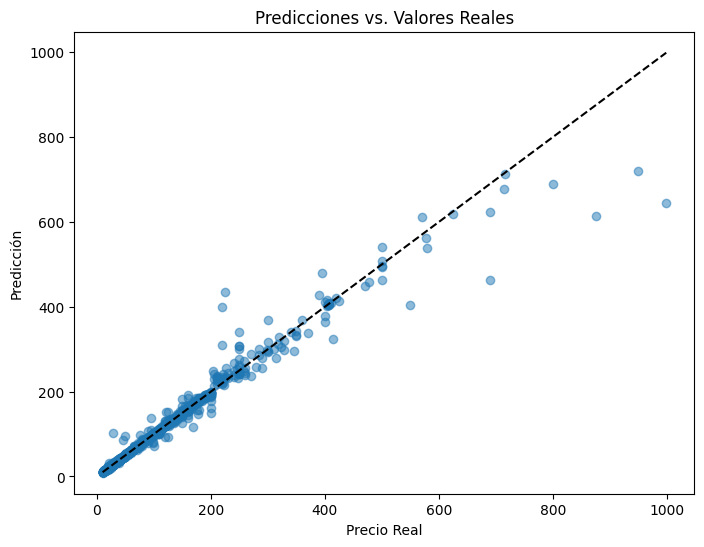

In [114]:
# Graficar Resultados
plt.figure(figsize=(8, 6))
plt.scatter(test["Price"], test["Final_Prediction"], alpha=0.5)
plt.plot([test["Price"].min(), test["Price"].max()],
         [test["Price"].min(), test["Price"].max()],
         color="black", linestyle="dashed")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")
plt.title("Predicciones vs. Valores Reales")
plt.show()

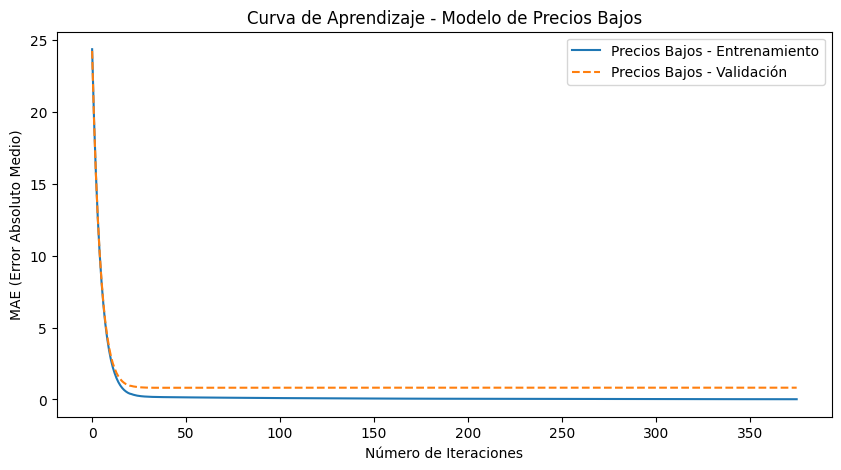

In [115]:
# Definir el modelo con eval_metric en la inicialización
xgb_low = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    **best_params_xgb_low
)

# Entrenar el modelo
xgb_low.fit(
    X_train_low, y_train_low,
    eval_set=[(X_train_low, y_train_low), (X_test_low, y_test_low)],
    verbose=False
)

# Extraer resultados correctamente
evals_result_low = xgb_low.evals_result()

# Graficar la Curva de Aprendizaje
plt.figure(figsize=(10, 5))
plt.plot(evals_result_low["validation_0"]["mae"], label="Precios Bajos - Entrenamiento")
plt.plot(evals_result_low["validation_1"]["mae"], label="Precios Bajos - Validación", linestyle="dashed")
plt.xlabel("Número de Iteraciones")
plt.ylabel("MAE (Error Absoluto Medio)")
plt.title("Curva de Aprendizaje - Modelo de Precios Bajos")
plt.legend()
plt.show()

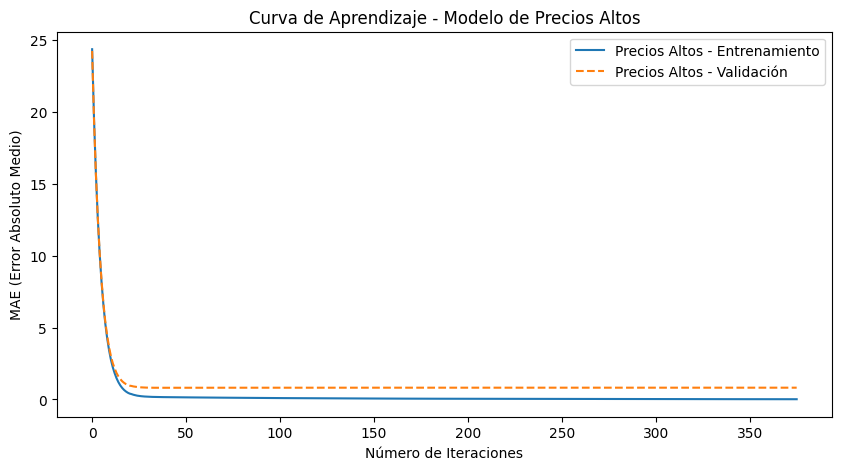

In [116]:
# Definir el modelo con eval_metric en la inicialización
xgb_high = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    **best_params_xgb_high
)

# Entrenar el modelo
xgb_high.fit(
    X_train_high, y_train_high,
    eval_set=[(X_train_high, y_train_high), (X_test_high, y_test_high)],
    verbose=False
)

# Extraer resultados correctamente
evals_result_high = xgb_high.evals_result()

# Graficar la Curva de Aprendizaje
plt.figure(figsize=(10, 5))
plt.plot(evals_result_low["validation_0"]["mae"], label="Precios Altos - Entrenamiento")
plt.plot(evals_result_low["validation_1"]["mae"], label="Precios Altos - Validación", linestyle="dashed")
plt.xlabel("Número de Iteraciones")
plt.ylabel("MAE (Error Absoluto Medio)")
plt.title("Curva de Aprendizaje - Modelo de Precios Altos")
plt.legend()
plt.show()

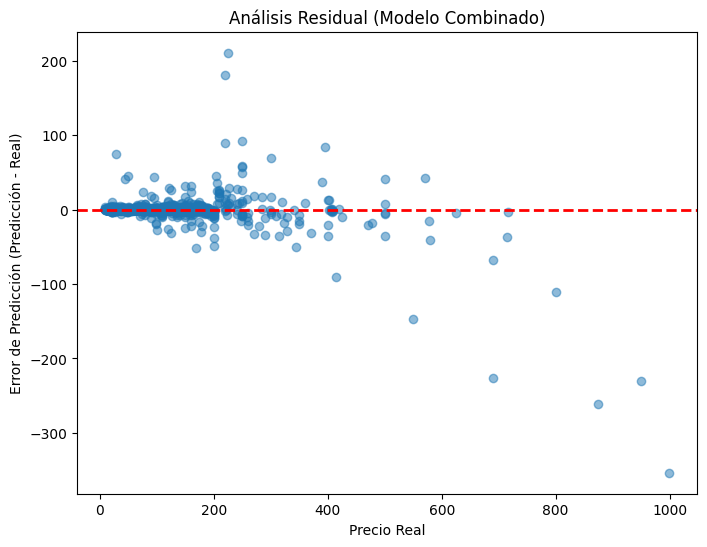

In [117]:
#2️ Análisis Residual (Distribución de Errores)
plt.figure(figsize=(8, 6))
plt.scatter(test["Price"], test["Final_Prediction"] - test["Price"], alpha=0.5)
plt.axhline(0, color="red", linestyle="dashed", linewidth=2)
plt.xlabel("Precio Real")
plt.ylabel("Error de Predicción (Predicción - Real)")
plt.title("Análisis Residual (Modelo Combinado)")
plt.show()

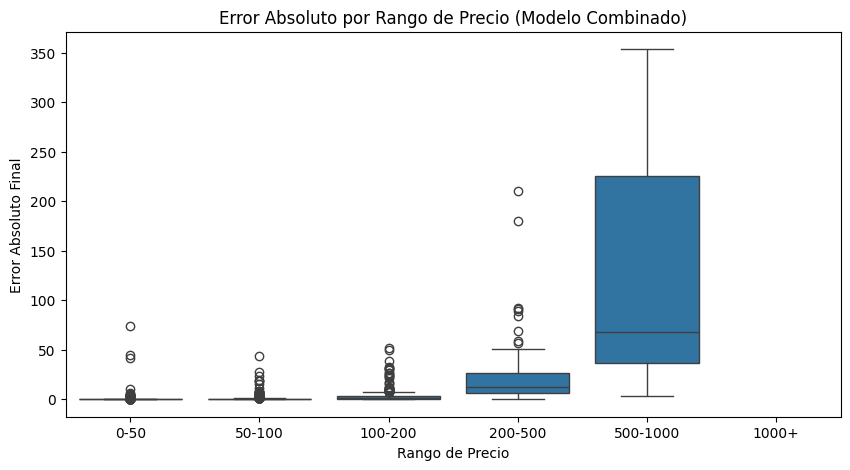

In [118]:
# Error Absoluto por Rango de Precio
test["Error_Final"] = abs(test["Price"] - test["Final_Prediction"])
test["Price_Range"] = pd.cut(test["Price"], bins=[0, 50, 100, 200, 500, 1000, 5000],
                             labels=["0-50", "50-100", "100-200", "200-500", "500-1000", "1000+"])

plt.figure(figsize=(10, 5))
sns.boxplot(x="Price_Range", y="Error_Final", data=test)
plt.xlabel("Rango de Precio")
plt.ylabel("Error Absoluto Final")
plt.title("Error Absoluto por Rango de Precio (Modelo Combinado)")
plt.show()

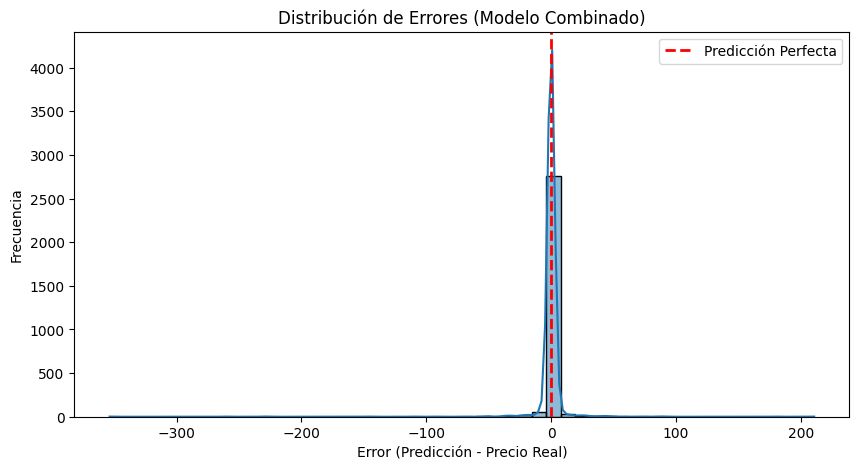

In [119]:
# Histograma de Errores
plt.figure(figsize=(10, 5))
sns.histplot(test["Final_Prediction"] - test["Price"], bins=50, kde=True)
plt.axvline(0, color="red", linestyle="dashed", linewidth=2, label="Predicción Perfecta")
plt.xlabel("Error (Predicción - Precio Real)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores (Modelo Combinado)")
plt.legend()
plt.show()

In [149]:
## Obtener la importancia de cada variable en xgb_lox
feature_importance = xgb_low.get_booster().get_score(importance_type="weight")

# Convertir a DataFrame y ordenarlo de mayor a menor
importance_df = pd.DataFrame(feature_importance.items(), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Mostrar las 20 variables más importantes
print("Top 20 variables más importantes en xgb_low:")
print(importance_df.head(20))

Top 20 variables más importantes en xgb_low:
                       Feature  Importance
0                   Host Since      4589.0
365      Price_per_accommodate      4120.0
2                 Accommodates      3484.0
10             Availability 30      1591.0
11            Availability 365      1551.0
12           Number of Reviews      1277.0
7                 Cleaning Fee      1226.0
1                Property Type      1163.0
13        Review Scores Rating       960.0
6             Security Deposit       887.0
3                    Bathrooms       843.0
5                         Beds       831.0
4                     Bedrooms       829.0
9                 Extra People       782.0
366  Bathrooms_per_accommodate       626.0
165       Description_tfidf_57       571.0
65            Summary_tfidf_57       516.0
8              Guests Included       430.0
166       Description_tfidf_58       403.0
30               Name_tfidf_62       338.0


In [148]:
## Obtener la importancia de cada variable en xgb_high
feature_importance = xgb_high.get_booster().get_score(importance_type="weight")

# Convertir a DataFrame y ordenarlo de mayor a menor
importance_df = pd.DataFrame(feature_importance.items(), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Mostrar las 20 variables más importantes
print("Top 20 variables más importantes en xgb_high:")
print(importance_df.head(20))

Top 20 variables más importantes en xgb_high:
                       Feature  Importance
241      Price_per_accommodate       461.0
2                 Accommodates       384.0
0                   Host Since       182.0
3                    Bathrooms        88.0
1                Property Type        88.0
11            Availability 365        72.0
10             Availability 30        64.0
29            Summary_tfidf_14        62.0
150       Description_tfidf_92        54.0
6             Security Deposit        51.0
36            Summary_tfidf_41        46.0
12           Number of Reviews        45.0
32            Summary_tfidf_21        44.0
5                         Beds        43.0
115       Description_tfidf_27        41.0
4                     Bedrooms        39.0
13        Review Scores Rating        37.0
242  Bathrooms_per_accommodate        36.0
131       Description_tfidf_53        35.0
7                 Cleaning Fee        34.0


In [120]:
#import joblib

# 📌 Guardar los modelos entrenados
joblib.dump(xgb_low, "xgb_model_low_prices.pkl")
joblib.dump(xgb_high, "xgb_model_high_prices.pkl")

print("Modelos guardados correctamente.")

✅ Modelos guardados correctamente.


# 7 - Otros modelos para high price. Comparación

In [128]:

# Escalar Datos (Mejora estabilidad)

scaler = StandardScaler()
X_train_high_esc = scaler.fit_transform(X_train_high)
X_test_high_esc = scaler.transform(X_test_high)

In [138]:
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#️ Entrenar Diferentes Modelos
models = {
    "Ridge Regression": Ridge(alpha=1.0, max_iter = 5000),
    "Lasso Regression": Lasso(alpha=0.1, max_iter = 5000),
    "Bayesian Ridge": BayesianRidge(),
    "Support Vector Regression": SVR(kernel="rbf", C=10, gamma="scale"),
    "k-Nearest Neighbors": KNeighborsRegressor(n_neighbors=3)
}

In [139]:
# Evaluar con Cross-Validation
results = {}
for name, model in models.items():
    score = cross_val_score(model, X_train_high_esc, y_train_high, cv=5, scoring="neg_mean_absolute_error").mean()
    results[name] = -score  # Guardar MAE positivo


In [140]:
# Seleccionar mejor modelo
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print(f"✅ Mejor modelo: {best_model_name} con MAE de {results[best_model_name]:.2f}")

✅ Mejor modelo: Bayesian Ridge con MAE de 85.48


In [141]:
# Entrenar y Evaluar el Mejor Modelo

best_model.fit(X_train_high_esc, y_train_high)
y_pred_high = best_model.predict(X_test_high_esc)

mae = mean_absolute_error(y_test_high, y_pred_high)
mse = mean_squared_error(y_test_high, y_pred_high)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_high, y_pred_high)

print("\n📊 Evaluación del Modelo Final:")
print(f"🔹 MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"🔹 MSE  (Error Cuadrático Medio): {mse:.2f}")
print(f"🔹 RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"🔹 R²   (Coeficiente de Determinación): {r2:.4f}")


📊 Evaluación del Modelo Final:
🔹 MAE  (Error Absoluto Medio): 90.71
🔹 MSE  (Error Cuadrático Medio): 16581.25
🔹 RMSE (Raíz del Error Cuadrático Medio): 128.77
🔹 R²   (Coeficiente de Determinación): 0.3725


In [144]:
pd.DataFrame(y_pred_high, columns=['predictions']).describe(), y_test_high.describe()

(       predictions
 count   113.000000
 mean    344.279778
 std      94.566474
 min     150.746943
 25%     283.108138
 50%     341.916746
 75%     398.363223
 max     693.018511,
 count    113.000000
 mean     349.283186
 std      163.273952
 min      204.000000
 25%      240.000000
 50%      290.000000
 75%      406.000000
 max      999.000000
 Name: Price, dtype: float64)